In [51]:
from pypdf import PdfReader
import re
import networkx as nx
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.cluster import SpectralClustering
from sklearn import metrics

Code par Igor Grégoire pour le cours LINMA1691 : Théorie des Graphes 

# Extraction et traitement des données


## On extrait le texte du pdf

In [52]:
reader = PdfReader('Star_Wars_Episode_3_Revenge_Of_The_Sith.pdf')
npages = len(reader.pages)
text = ''
for i in range(npages):
    page = reader.pages[i]
    text += page.extract_text()


## On traite le texte pour diviser le script en scènes

In [53]:
temp = text.split('\n')
data = []

# On localise les scènes
scenes = []
for i in range(len(temp)):
    # George Lucas a oublié de mettre des points à tous les INT et EXT...
    if ("INT" in temp[i] or "EXT" in temp[i]) and "INTERCUT" not in temp[i]:
        scenes.append(i)

# On divise les scènes dans data
for i in range(len(scenes)-1):
    data.append(temp[scenes[i]:scenes[i+1]])
data.append(temp[scenes[-1]:])




## On cherche les personnages parlant dans chaque scène

In [54]:
characters = {}
pattern = r'\b[A-Za-z][A-Za-z0-9\- ]+:'
for i in range(len(data)):
    temp = ''.join(data[i][1:])
    personnages = re.findall(pattern, temp)
    personnages = [personnages[m].upper() for m in range(len(personnages))]
    if i not in characters:
        characters[i] = []
    for personnage in personnages:
        if personnage[:-1] not in characters[i]:
            characters[i].append(personnage[:-1])

## On corrige les fautes de frappe

In [55]:
error = 0
# G-3PO
characters[161].remove('G-3PO')
error += 1
 
# Qui -Gon
characters[221].remove('QUI -GON')
error += 1

# ANAKINN
characters[52].remove('ANAKINN')
error += 1

# Obi-Wan  (avec espace)
characters[85].remove('OBI-WAN ')
error += 1

# Dabth sidious
characters[140].remove('DABTH SIDIOUS')
characters[140].append('DARTH SIDIOUS')
error += 1

# Some errors
characters[7].remove(characters[7][3])
characters[129].remove(characters[129][0])
characters[115].remove(characters[115][0])
characters[104].remove(characters[104][2])
error += 4

for i in characters:
    if 'MACE' in characters[i]:
        characters[i].remove('MACE')
        if "MACE WINDU" not in characters[i]:
            characters[i].append('MACE WINDU')
        error += 1

    if 'MACE WLNDU' in characters[i]:
        characters[i].remove('MACE WLNDU')
        if "MACE WINDU" not in characters[i]:
            characters[i].append('MACE WINDU')
        error += 1

    if 'BAIL' in characters[i]:
        characters[i].remove('BAIL')
        if "BAIL ORGANA" not in characters[i]:
            characters[i].append('BAIL ORGANA')
        error += 1

    if 'DARTH SLDIOUS' in characters[i]:
        characters[i].remove('DARTH SLDIOUS')
        if "DARTH SIDIOUS" not in characters[i]:
            characters[i].append('DARTH SIDIOUS')
        error += 1

print("Nombre d'erreurs (hors fautes de majuscule): ", error)

Nombre d'erreurs (hors fautes de majuscule):  25


# Début du graphe

## Liste d'adjacence

In [56]:
nodes = []
edges = []

for i in characters:
    if len(characters[i]) >= 2:
        edges.append(characters[i])

    for j in characters[i]:
        if j not in nodes:
            nodes.append(j)
            
# sort nodes alphabetically
nodes.sort()
Nnodes = len(nodes)

# Faire la liste d'adjacence
adj = {}
for node in nodes:
    adj[node] = []

# Remplir la liste d'adjacence
for edge in edges:
    for i in range(len(edge)):
        adj[edge[i]] += edge[:i] + edge[i+1:]

## Création du graphe

In [57]:
# Graphe entier
G = nx.Graph()

for i in nodes:
    G.add_node(i)

for i in G.nodes():
    for j in adj[i]:
        if not G.has_edge(i, j):
            G.add_edge(i, j, weight=1)
        else:
            G[i][j]['weight'] += 1

### Plot du graphe

Graph with 65 nodes and 161 edges


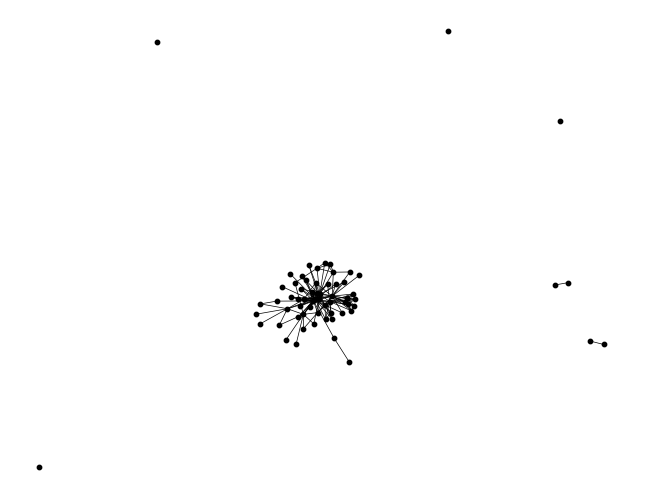

In [ ]:
g_draw = G
pos = nx.spring_layout(g_draw)
nx.draw(g_draw, pos, node_color='black', node_size=10, width=0.5)
print(G)
#plt.savefig("graphG.png")

### Degrees

Text(0.5, 1.0, 'Degree distribution')

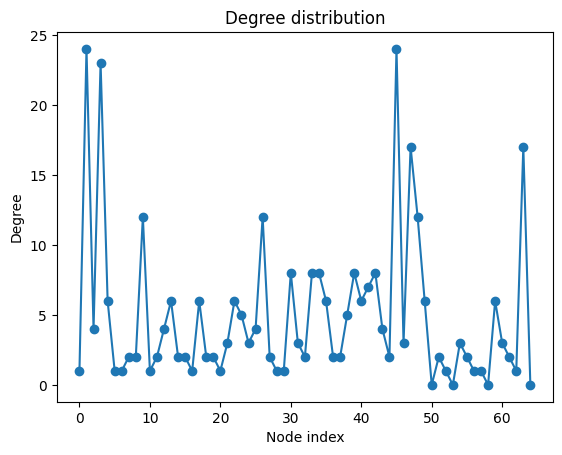

In [59]:
degrees = [G.degree(node) for node in nodes]
plt.plot(degrees,  linestyle='-', marker='o')
plt.xlabel('Node index')
plt.ylabel('Degree')
plt.title('Degree distribution')


Text(0.5, 1.0, 'Degree distribution')

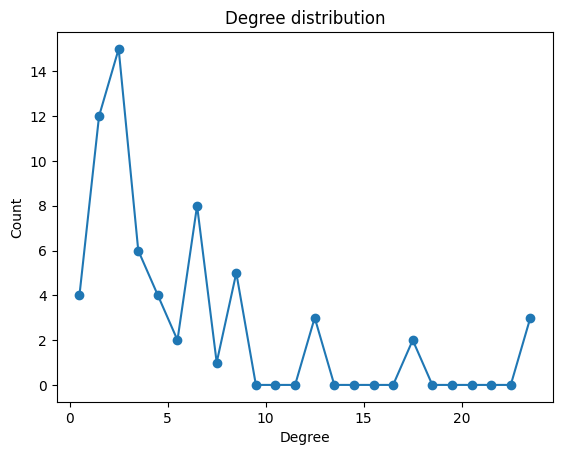

In [60]:
b_width = 1
bins = np.arange(min(degrees), max(degrees)+b_width, b_width)
hist, bins = np.histogram(degrees, bins = bins)
center_bins = [l+b_width/2 for l in bins[:-1]]

plt.plot(center_bins, hist, marker = "o")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.title("Degree distribution")


## Composantes connexes
Identification des composantes connexes

In [61]:
connect = nx.is_connected(G)
N_connected = nx.number_connected_components(G)
max_connected = max(nx.connected_components(G), key=len)
max_cc = G.subgraph(max_connected)



print("Le graphe est-il connexe ? ", connect)
print("Nombre de composantes connexes : ", N_connected)


Le graphe est-il connexe ?  False
Nombre de composantes connexes :  7


On plot la composante connexe la plus grande

Graph with 57 nodes and 159 edges


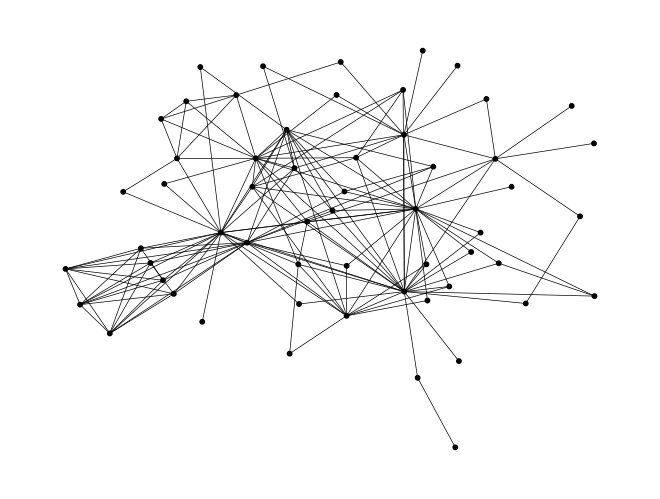

In [71]:
cc_draw = max_cc

color = np.array(["black"] * len(max_cc.nodes()))

# pos = nx.spring_layout(cc_draw)
pos = nx.kamada_kawai_layout(cc_draw)
# pos = nx.arf_layout(cc_draw)
nx.draw(cc_draw, pos, node_color=color, node_size=10, width=0.5)
#plt.savefig("graphCC.png")

print(max_cc)

## Coloriage des noeuds

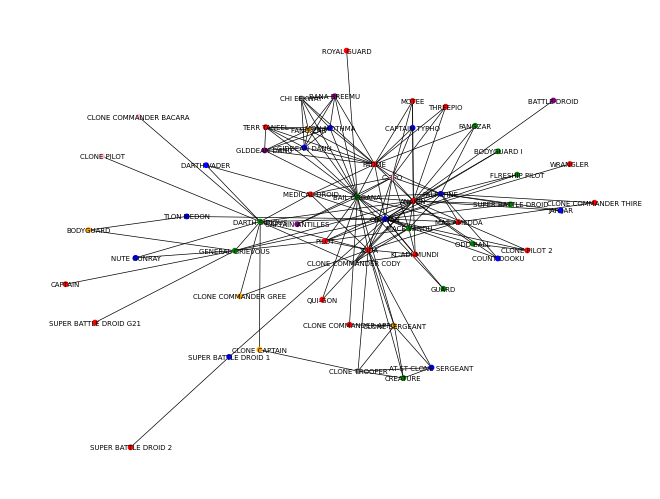

In [63]:
coloring = nx.coloring.greedy_color(max_cc, strategy='largest_first')
color = []
list_color = ["red", "blue", "green", "purple", "orange", "pink", "grey", "cyan"]
for i in coloring:
    color.append(list_color[coloring[i]])

pos = nx.spring_layout(cc_draw)
nx.draw(cc_draw, pos, node_color=color, node_size=10, width=0.5, with_labels=True, font_size=5)

## Spectral clustering

In [64]:
adjacency_matrix = nx.adjacency_matrix(max_cc)
# pos = nx.spring_layout(cc_draw)
pos = nx.kamada_kawai_layout(cc_draw)
# pos = nx.shell_layout(cc_draw)
# pos = nx.arf_layout(cc_draw)

Silhouette score:  -0.3774758521337043


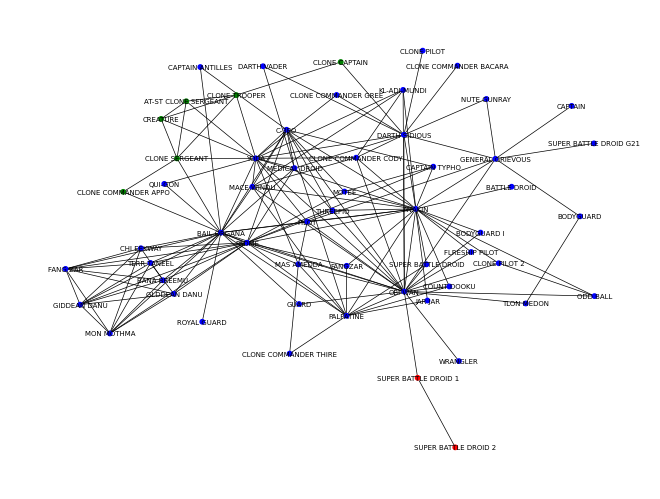

In [65]:
sc = SpectralClustering(3, affinity='precomputed', n_init=100)
sc.fit(adjacency_matrix)
labels = sc.labels_

# Draw the graph with the clustering
color = []
for i in labels:
    color.append(list_color[i])

nx.draw(cc_draw, pos, node_color=color, node_size=10, width=0.5, with_labels=True, font_size=5)

silhouette = metrics.silhouette_score(adjacency_matrix, labels, metric='euclidean')
print("Silhouette score: ", silhouette)

c:\Users\grego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Silhouette score:  -0.0236114528536173


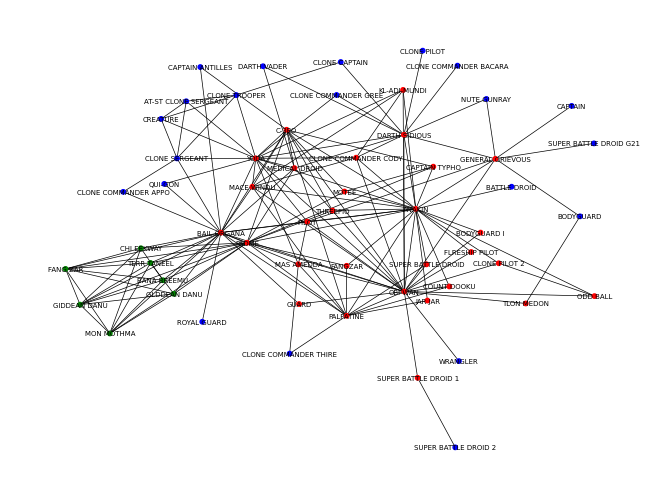

In [66]:
sc = SpectralClustering(3, affinity='nearest_neighbors', n_init=100)
sc.fit(adjacency_matrix)
labels = sc.labels_

# Draw the graph with the clustering
color = []
for i in labels:
    color.append(list_color[i])

nx.draw(cc_draw, pos, node_color=color, node_size=10, width=0.5, with_labels=True, font_size=5)

silhouette = metrics.silhouette_score(adjacency_matrix, labels, metric='euclidean')
print("Silhouette score: ", silhouette)

c:\Users\grego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
c:\Users\grego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\grego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Silhouette score:  0.5661344263972495


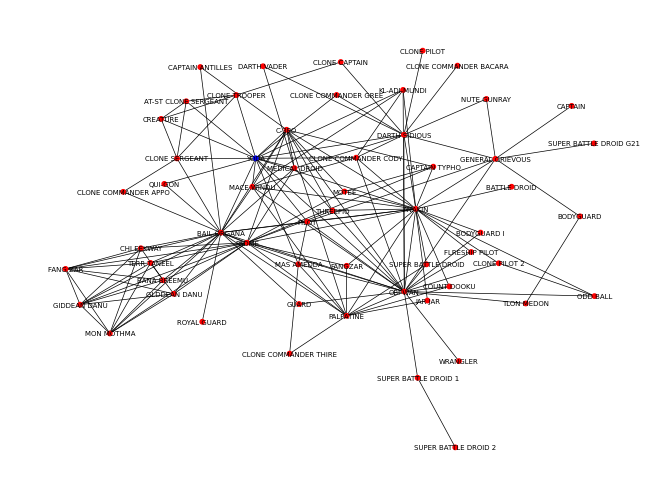

In [67]:
sc = SpectralClustering(3, affinity='rbf', n_init=100)
sc.fit(adjacency_matrix)
labels = sc.labels_

# Draw the graph with the clustering
color = []
for i in labels:
    color.append(list_color[i])

nx.draw(cc_draw, pos, node_color=color, node_size=10, width=0.5, with_labels=True, font_size=5)

silhouette = metrics.silhouette_score(adjacency_matrix, labels, metric='euclidean')
print("Silhouette score: ", silhouette)